# Selecting good and bad scenes

- choose metric between METRIC=$||U_{field} - U_{drifter}||$ and METRIC_NORMA=$\frac{||U_{field} - U_{drifter}||}{||U_{drifter}||}$ 

- result : METRIC_NORMA is best (outliers are removed)

#### Imports

In [1]:
import sys
import os

import numpy as np
import xarray as xr
import pandas as pd


sys.path.append(os.path.abspath(os.path.join('..', 'common_utils')))
from utils import *
from utils_plots import plot_scene
import Drifters_processing


%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.dpi'] = 300

### Load data

In [2]:
# 3.5km filter + drifter filter velocity
dir_scenes_liss5 = '/home/bouxdecl/Documents/MEOM_driftersCompa/data/results/Scene_3point5kmfilterfield_48hfilterdrifter'
ds_swot_3point5 = xr.open_dataset('/home/bouxdecl/Documents/MEOM_driftersCompa/data/fields/field_L3SWOT_3point5km_Noneh.nc')


####
dir_scenes = dir_scenes_liss5
field = ds_swot_3point5
####

In [3]:
scenes = xr.open_mfdataset([os.path.join(dir_scenes, f) for f in os.listdir(dir_scenes)], combine='nested', concat_dim='scene')
scenes = scenes.rename_vars({'u_geo':'u_geo_swot', 'v_geo':'v_geo_swot', 'u_var':'u_var_swot', 'v_var':'v_var_swot'})
scenes = Drifters_processing.all_add_metrics(scenes)
S = scenes.where(scenes.n_points_compa > 96, drop=True) #remove scenes with less than 2 days of field comparison

S.sizes

Frozen({'scene': 187, 's_obs': 144})

### Scenes repartitions

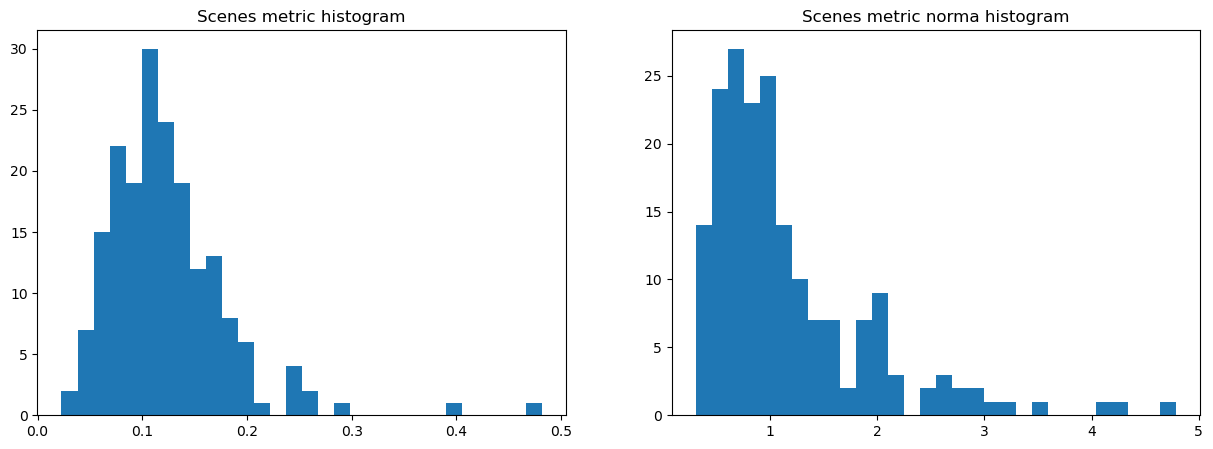

In [9]:
matplotlib.rcParams['figure.dpi'] = 100

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Scenes metric histogram')
_ = plt.hist(S.metric_var.mean(dim='s_obs').values, bins=30)
plt.subplot(1, 2, 2)
plt.title('Scenes metric norma histogram')
_ = plt.hist(S.metric_norma_var.mean(dim='s_obs').values, bins=30)

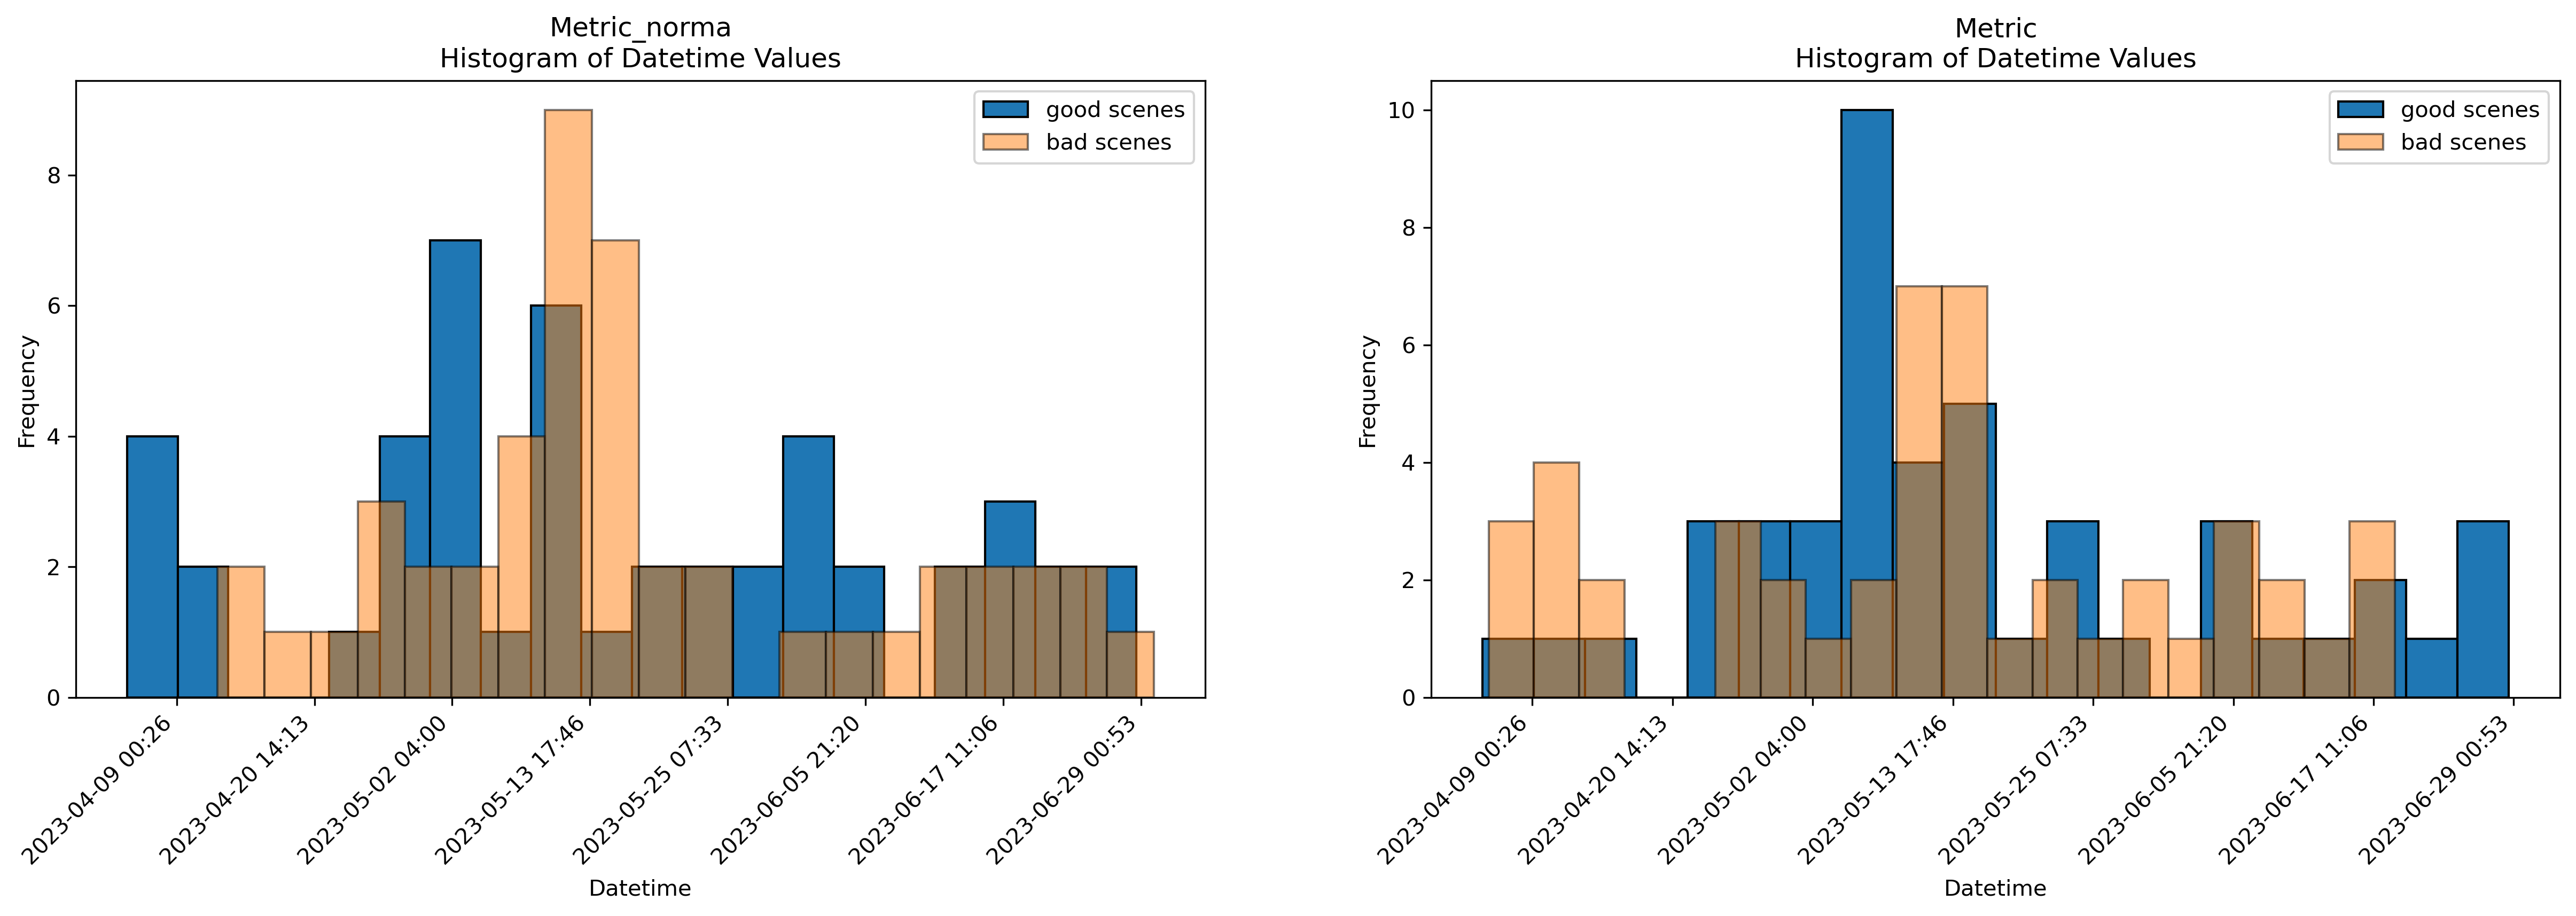

In [50]:
n = 47

GOODnorma_scenes = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(n))
BADnorma_scenes  = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(-n, None))

GOOD_scenes = S.sortby(S.metric_var.mean(dim='s_obs')).isel(scene=slice(n))
BAD_scenes  = S.sortby(S.metric_var.mean(dim='s_obs')).isel(scene=slice(-n, None))


####

timestamps = GOOD_scenes.time.mean('s_obs').values.astype('datetime64[s]').astype(int)
timestamps2 = BAD_scenes.time.mean('s_obs').values.astype('datetime64[s]').astype(int)

# Plot histogram
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.title('metric')
plt.hist(timestamps, bins=20, edgecolor='black', label='good scenes')
plt.hist(timestamps2, bins=20, edgecolor='black', label='bad scenes', alpha=0.5)

# Format the x-axis to show readable datetime values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x, unit='s').strftime('%Y-%m-%d %H:%M')))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Datetime')
plt.ylabel('Frequency')
plt.title('Metric_norma\nHistogram of Datetime Values')
plt.legend()

timestamps = GOODnorma_scenes.time.mean('s_obs').values.astype('datetime64[s]').astype(int)
timestamps2 = BADnorma_scenes.time.mean('s_obs').values.astype('datetime64[s]').astype(int)

# Plot histogram
plt.subplot(1, 2, 2)
plt.hist(timestamps, bins=20, edgecolor='black', label='good scenes')
plt.hist(timestamps2, bins=20, edgecolor='black', label='bad scenes', alpha=0.5)

# Format the x-axis to show readable datetime values
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x, unit='s').strftime('%Y-%m-%d %H:%M')))
plt.xticks(rotation=45, ha='right')
plt.xlabel('Datetime')
plt.ylabel('Frequency')
plt.title('Metric\nHistogram of Datetime Values')
plt.legend()
plt.show()

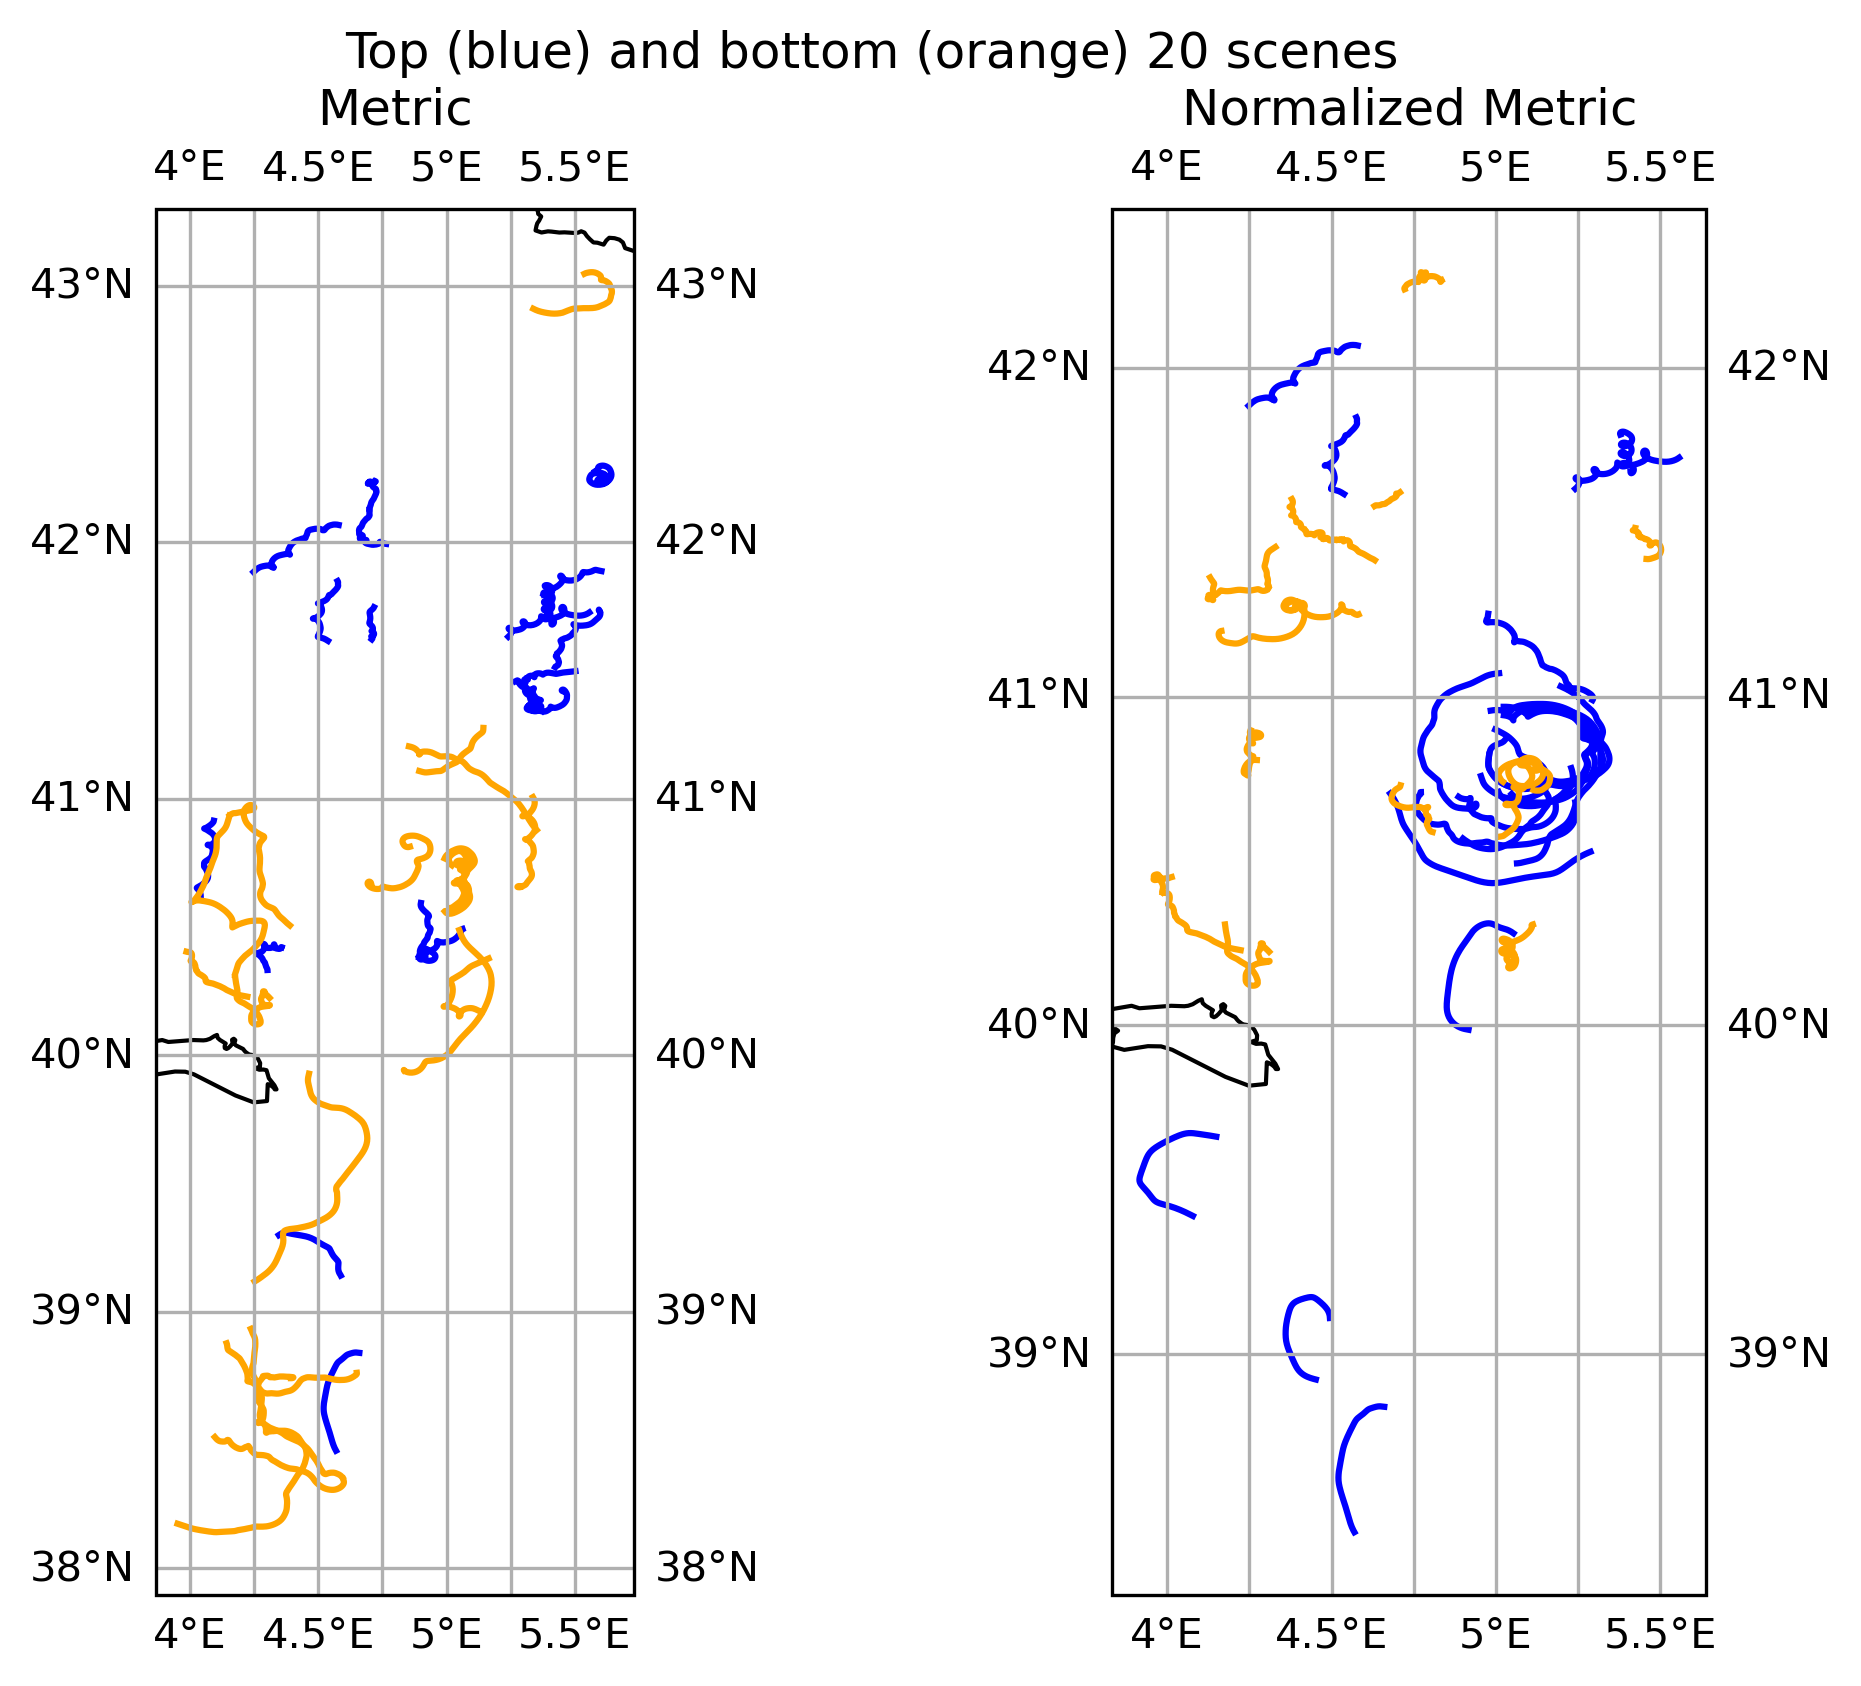

In [53]:
n = 20

GOODnorma_scenes = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(n))
BADnorma_scenes  = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(-n, None))

GOOD_scenes = S.sortby(S.metric_var.mean(dim='s_obs')).isel(scene=slice(n))
BAD_scenes  = S.sortby(S.metric_var.mean(dim='s_obs')).isel(scene=slice(-n, None))



matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Define a function to plot the trajectories on a given axis
def plot_trajectories(ax, GOODnorma_scenes, BADnorma_scenes):
    ax.coastlines()

    # Plot each GOOD trajectory
    for scene_idx in range(GOODnorma_scenes.sizes['scene']):
        lon = GOODnorma_scenes.isel(scene=scene_idx).lon_filtered
        lat = GOODnorma_scenes.isel(scene=scene_idx).lat_filtered
        ax.plot(lon, lat, c='b')

    # Plot each BAD trajectory
    for scene_idx in range(BADnorma_scenes.sizes['scene']):
        lon = BADnorma_scenes.isel(scene=scene_idx).lon_filtered
        lat = BADnorma_scenes.isel(scene=scene_idx).lat_filtered
        ax.plot(lon, lat, c='orange')

    # Add gridlines
    ax.gridlines(draw_labels=True)

# Plot on the first subplot
plot_trajectories(ax1, GOOD_scenes, BAD_scenes)
ax1.set_title('Metric')

# Plot on the second subplot (same data for demonstration)
plot_trajectories(ax2, GOODnorma_scenes, BADnorma_scenes)
ax2.set_title('Normalized Metric')

fig.suptitle('Top (blue) and bottom (orange) {} scenes'.format(n))
# Display the plots
plt.show()

### See the top 10 and bottom 10 scenes

In [56]:
n = 20

GOODnorma_scenes = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(n))
BADnorma_scenes  = S.sortby(S.metric_norma_var.mean(dim='s_obs')).isel(scene=slice(-n, None))

In [57]:
scenes = GOODnorma_scenes

for idx in range(scenes.sizes['scene']):
    plot_scene(scenes.isel(scene=idx), field, field_vec='both', time_point=6, points_hours=6, 
               add_title='\nmetric norma = {:.2f}'.format(scenes.isel(scene=idx).metric_norma_geo.mean('s_obs')),
               plot=False, 
               save_name='GOOD_norma_scene_{}'.format(idx),
               save_dir= '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-07-17_Scenes_GOODBAD_3point5km_48h'
               )

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py

In [58]:
scenes = BADnorma_scenes

for idx in range(scenes.sizes['scene']):
    plot_scene(scenes.isel(scene=idx), field, field_vec='both', time_point=6, points_hours=6, 
               add_title='\nmetric norma = {:.2f}'.format(scenes.isel(scene=idx).metric_norma_geo.mean('s_obs')),
               plot=False, 
               save_name='BAD_norma_scene_{}'.format(idx),
               save_dir= '/home/bouxdecl/Documents/MEOM_internship_2024/save_plots/save_plots_2024-07-17_Scenes_GOODBAD_3point5km_48h'
               )

/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1642: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contourf(*args, **kwargs)
/home/bouxdecl/miniconda3/envs/gdp6h_duacs_jaxparrow/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py